In [1124]:
import random
import matplotlib.pyplot as plt
import numpy as np

# --- Theory: ---
# This simulation models a simple ecosystem with plants, rabbits (prey), and wolves (predators).
# Population dynamics are governed by resource availability, density-dependent feedbacks, and stochastic events.
# The model incorporates energy budgets, age structure, and functional responses to prey density.

class Plant:
    def __init__(self, size, max_size, grow_rate):
        # Plant size is limited by min and max size, and grows each step.
        self.size = size
        self.grow_rate = grow_rate
        self.min_size = 5
        self.max_size = max_size

    def step(self):
        # Plant growth: increases by a fixed rate and a percentage of max size.
        self.size *= random.uniform(0.9, 1.3)
        self.size += (self.grow_rate * self.max_size)
        if self.size > self.max_size:
            self.size = self.max_size
        if self.size <= self.min_size:
            self.size = self.min_size

    def update(self, eat_amount):
        # Plant is eaten by rabbits; can't go below min size.
        self.size -= eat_amount
        if self.size <= self.min_size:
            self.size = self.min_size

class Animal:
    def __init__(self, type, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        # Animal base class: stores type, eating/breeding parameters, and state.
        self.type = type
        self.eat_amount = max(eat_amount, 2)
        self.eat_rate = max(eat_rate, 0.1)
        self.emergency_eat_ratio = max(emergency_eat_ratio, 1)
        self.breed_rate = max(breed_rate, 0.1)
        self.is_alive = True
        self.hunger = 100  # If zero, the animal is dead.
        # self.age = 0
        self.max_age = random.randint(50, 100)  # Random max age between 50-100 steps
        self.old_age_threshold = int(self.max_age * 0.7)  # 70% of max age
        
        self.age = random.randint(0, int(self.max_age * 0.2))  # Random initial age up to 30% of max_age

    def step(self):
        # Age and hunger update; death if hunger < 0 or max age reached.
        if self.hunger < 0:
            self.is_alive = False
        self.age += 1
        # Increased mortality for old animals
        if self.age > self.old_age_threshold:
            age_factor = (self.age - self.old_age_threshold) / (self.max_age - self.old_age_threshold)
            if random.random() < age_factor * 0.1:
                self.is_alive = False
        if self.age >= self.max_age:
            self.is_alive = False

    def print(self):
        # print(f"{self.type} - {self.hunger} - {self.eat_amount} - {self.eat_rate} - {self.emergency_eat_ratio} - {self.breed_rate}")
        print("Type:", self.type)
        print("Hunger:", self.hunger)
        print("Eat amount:", self.eat_amount)
        print("Eat rate:", self.eat_rate)
        print("Emergency eat ratio:", self.emergency_eat_ratio)
        print("Breed rate:", self.breed_rate)
        print("Age:", self.age)

class Rabbit(Animal):
    def __init__(self, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        # Rabbit is a prey animal with lower max age and hunger.
        super().__init__('prey', eat_amount, eat_rate, emergency_eat_ratio, breed_rate)
        self.hunger = 60
        self.max_hunger = 60
        self.actions = []
        self.max_age = random.randint(8, 12)  # Rabbits live shorter
        self.old_age_threshold = int(self.max_age * 0.7)

    def step(self, plant: Plant):
        self.age += 1
        # --- Theory: ---
        # Rabbits lose energy each step, eat plants to regain hunger, and may breed.
        # Their actions depend on hunger and random chance, with forced eating if starving.
        step_cost = max(self.eat_amount // 3, 4)
        if self.hunger < self.max_hunger:
            step_cost *= 1.6
            step_cost = int(step_cost)
        # Old rabbits pay higher energy cost
        if self.age > self.old_age_threshold:
            age_factor = (self.age - self.old_age_threshold) / (self.max_age - self.old_age_threshold)
            step_cost *= (1 + age_factor * 0.5)
        self.hunger -= step_cost
        self.actions = []
        # Action selection: eat if starving, else random chance to eat or sleep
        if self.hunger < self.eat_amount * self.emergency_eat_ratio:
            self.actions.append('eat')
        elif random.random() < self.eat_rate:
            self.actions.append('eat')
        else:
            self.actions.append('sleep')
        # Random chance to breed
        if random.random() < self.breed_rate:
            self.actions.append('breeding')
        for action in self.actions:
            if action == 'eat':
                if self.eat_amount < plant.size * random.uniform(1, 1.2):
                    num_eaten = random.randint(self.eat_amount, int(self.eat_amount * (1 + self.eat_rate)))
                    self.hunger += num_eaten
                    self.hunger = min(self.hunger, self.max_hunger)
                    plant.update(self.eat_amount * random.uniform(0.7, 1))
                else:
                    self.hunger -= step_cost
            if self.hunger < 0:
                self.is_alive = False
                break

    def breed(self, other_rabbit):
        # --- Theory: ---
        # Breeding costs energy, and success depends on age.
        self.hunger -= self.eat_amount // 6
        other_rabbit.hunger -= self.eat_amount // 6
        
        # age_factor_self = 1 - (self.age / self.max_age)
        # age_factor_other = 1 - (other_rabbit.age / other_rabbit.max_age)
        # if random.random() > (age_factor_self + age_factor_other) / 2:
        #     return None  # Failed breeding attempt
        
        shared_eat_amount = int((self.eat_amount + other_rabbit.eat_amount) / 2 + random.randint(-2, 2))
        shared_eat_rate = (self.eat_rate + other_rabbit.eat_rate) / 2 + random.uniform(-0.2, 0.2)
        shared_emergency_eat_ratio = (self.emergency_eat_ratio + other_rabbit.emergency_eat_ratio) / 2 + random.uniform(-0.1, 0.1)
        shared_breed_rate = (self.breed_rate + other_rabbit.breed_rate) / 2 + random.uniform(-0.1, 0.1)
        
        rabbit = Rabbit(shared_eat_amount, shared_eat_rate, shared_emergency_eat_ratio, shared_breed_rate)
        rabbit.hunger = int((self.hunger + other_rabbit.hunger) / 2)
        rabbit.age = 0
        rabbit.max_age = int((self.max_age + other_rabbit.max_age) / 2 + random.randint(-5, 5))
        rabbit.max_age = max(rabbit.max_age, 8)
        rabbit.old_age_threshold = int(rabbit.max_age * 0.7)
        return rabbit
    
class Wolf(Animal):
    def __init__(self, eat_amount, eat_rate, emergency_eat_ratio, breed_rate):
        # Wolf is a predator with higher max age and hunger.
        super().__init__('predator', eat_amount, eat_rate, emergency_eat_ratio, breed_rate)
        self.hunger = 80
        self.max_hunger = 120
        self.max_age = random.randint(13, 18)  # Wolves live longer
        self.actions = []

    def step(self, rabbit: Rabbit, num_rabbits: int, num_wolves: int):
        self.age += 1
        # --- Theory: ---
        # Wolves adjust hunting and breeding based on predator:prey ratio (density dependence).
        # High wolf:rabbit ratio = more competition, more hunting, less breeding.
        # Low ratio = less competition, normal breeding.
        step_cost = max(self.eat_amount // 3, 6)
        if self.hunger < self.max_hunger / 2:
            step_cost *= 1.2
            step_cost = int(step_cost)
        self.hunger -= step_cost
        self.actions = []
        # Action selection: hunt if hungry, else random chance to hunt or sleep
        if self.hunger < self.eat_amount * self.emergency_eat_ratio:
            self.actions.append('hunt')
        elif random.random() < self.eat_rate:
            self.actions.append('hunt')
        else:
            self.actions.append('sleep')
        ratio = num_wolves / (num_rabbits + 1e-6)
        if ratio > 0.1:
            self.eat_rate = min(1, self.eat_rate * 1.5)
            effective_breed_rate = self.breed_rate * 0.18
        else:
            effective_breed_rate = self.breed_rate
        if random.random() < effective_breed_rate:
            self.actions.append('breeding')
        k = 60
        density_factor = (num_rabbits ** 2) / (num_rabbits ** 2 + k ** 2)
        hunt_success_rate = min(0.7, 0.7 * density_factor)

        # if self.age > self.old_age_threshold:
        #     age_factor = (self.age - self.old_age_threshold) / (self.max_age - self.old_age_threshold)
        #     step_cost *= (1 + age_factor * 0.3)
        #     hunt_success_rate = min(0.7, 0.7 * density_factor * (1 - age_factor * 0.5))
        # else:
        #     hunt_success_rate = min(0.7, 0.7 * density_factor)

        # Hardcoded hunt success rate
        # hunt_success_rate = random.uniform(0.3, 0.4)    
        for action in self.actions:
            if action == 'hunt' and rabbit is not None and rabbit.is_alive:
                if random.random() < hunt_success_rate:
                    # Wolf gets nutrition based on rabbit's hunger directly, not eat_amount
                    nutrition = rabbit.hunger
                    self.hunger += nutrition * 3
                    self.hunger = min(self.hunger, self.max_hunger)
                    rabbit.is_alive = False
                else:
                    self.hunger -= step_cost
            if self.hunger < 0:
                self.is_alive = False
                break
    def breed(self, other_wolf):
        # --- Theory: ---
        # Breeding costs energy, and success depends on age.
        self.hunger -= self.eat_amount // 4
        other_wolf.hunger -= self.eat_amount // 4

        # age_factor_self = 1 - (self.age / self.max_age)
        # age_factor_other = 1 - (other_wolf.age / other_wolf.max_age)
        # if random.random() > (age_factor_self + age_factor_other) / 2:
        #     return None
        
        shared_eat_amount = int((self.eat_amount + other_wolf.eat_amount) / 2 + random.randint(-2, 2))
        shared_eat_rate = (self.eat_rate + other_wolf.eat_rate) / 2 + random.uniform(-0.05, 0.05)
        shared_emergency_eat_ratio = (self.emergency_eat_ratio + other_wolf.emergency_eat_ratio) / 2 + random.uniform(-0.1, 0.1)
        shared_breed_rate = (self.breed_rate + other_wolf.breed_rate) / 2 + random.uniform(-0.05, 0.05)
        wolf = Wolf(shared_eat_amount, shared_eat_rate, shared_emergency_eat_ratio, shared_breed_rate)
        wolf.age = 0
        wolf.hunger = int((self.hunger + other_wolf.hunger) / 2)
        wolf.max_age = int((self.max_age + other_wolf.max_age) / 2 + random.randint(-5, 5))
        wolf.max_age = max(wolf.max_age, 13)
        wolf.old_age_threshold = int(wolf.max_age * 0.7)
        return wolf


In [1125]:
from dataclasses import dataclass
from typing import List, Tuple
from collections import defaultdict

@dataclass
class RabbitProperties:
    eat_amount: Tuple[int, int]
    eat_rate: Tuple[float, float]
    emergency_eat_ratio: Tuple[float, float]
    breed_rate: Tuple[float, float]
    num_rabbits: int

@dataclass
class WolfProperties:
    eat_amount: Tuple[int, int]
    eat_rate: Tuple[float, float]
    emergency_eat_ratio: Tuple[float, float]
    breed_rate: Tuple[float, float]
    num_wolves: int

@dataclass
class PlantProperties:
    size: float
    max_size: float
    grow_rate: float

class Environment:
    def __init__(self, rabbit_properties: RabbitProperties, plant_properties: PlantProperties, wolf_properties: WolfProperties = None):
        # --- Theory: ---
        # The environment manages all agents and simulates ecosystem dynamics step by step.
        self.ep = 0
        self.rabbits = [
            Rabbit(
                eat_amount=random.randint(*rabbit_properties.eat_amount),
                eat_rate=random.uniform(*rabbit_properties.eat_rate),
                emergency_eat_ratio=random.uniform(*rabbit_properties.emergency_eat_ratio),
                breed_rate=random.uniform(*rabbit_properties.breed_rate),
            ) for _ in range(rabbit_properties.num_rabbits)
        ]
        self.wolves = []
        if wolf_properties:
            self.wolves = [
                Wolf(
                    eat_amount=random.randint(*wolf_properties.eat_amount),
                    eat_rate=random.uniform(*wolf_properties.eat_rate),
                    emergency_eat_ratio=random.uniform(*wolf_properties.emergency_eat_ratio),
                    breed_rate=random.uniform(*wolf_properties.breed_rate),
                ) for _ in range(wolf_properties.num_wolves)
            ]
        self.plant = Plant(
            size=plant_properties.size,
            max_size=plant_properties.max_size,
            grow_rate=plant_properties.grow_rate
        )
        self.report = []

    def update_report(self):
        # Collect population and resource stats for plotting/analysis.
        report = {
            'num_rabbits': len(self.rabbits),
            'num_wolves': len(self.wolves),
            'plant_size': self.plant.size,
            'rabbit_stats': {},
            'wolf_stats': {},
        }

        rabbit_avg_stats = defaultdict(list)
        for rabbit in self.rabbits:
            rabbit_avg_stats['rabbit_hunger'].append(rabbit.hunger)
            rabbit_avg_stats['rabbit_age'].append(rabbit.age)
            rabbit_avg_stats['rabbit_eat_amount'].append(rabbit.eat_amount)
            rabbit_avg_stats['rabbit_eat_rate'].append(rabbit.eat_rate)
            rabbit_avg_stats['rabbit_emergency_eat_ratio'].append(rabbit.emergency_eat_ratio)
            rabbit_avg_stats['rabbit_breed_rate'].append(rabbit.breed_rate)
        
        for key, value in rabbit_avg_stats.items():
            report['rabbit_stats'][key] = sum(value) / len(value)


        wolf_avg_stats = defaultdict(list)
        for wolf in self.wolves:
            wolf_avg_stats['wolf_hunger'].append(wolf.hunger)
            wolf_avg_stats['wolf_age'].append(wolf.age)
            wolf_avg_stats['wolf_eat_amount'].append(wolf.eat_amount)
            wolf_avg_stats['wolf_eat_rate'].append(wolf.eat_rate)
            wolf_avg_stats['wolf_emergency_eat_ratio'].append(wolf.emergency_eat_ratio)
            wolf_avg_stats['wolf_breed_rate'].append(wolf.breed_rate)

        for key, value in wolf_avg_stats.items():
            report['wolf_stats'][key] = sum(value) / len(value)

        self.report.append(report)

    def remove_dead_animals(self):
        # Remove dead animals from the simulation.
        self.rabbits = [rabbit for rabbit in self.rabbits if rabbit.is_alive]
        self.wolves = [wolf for wolf in self.wolves if wolf.is_alive]

    def simulate(self):
        # --- Theory: ---
        # Each step: update all agents, handle breeding, update plant, and record stats.
        self.update_report()
        for rabit in self.rabbits:
            rabit.step(self.plant)
        self.report[-1]['plant_size'] = self.plant.size
        
        if len(self.rabbits) > 0:
            selected_rabbits = random.choices(self.rabbits, k=len(self.wolves))
        else:
            selected_rabbits = [None] * len(self.wolves)
        for i, wolf in enumerate(self.wolves):
            wolf.step(selected_rabbits[i], len(self.rabbits), len(self.wolves))
        self.remove_dead_animals()
        breeding_rabbits = [rabbit for rabbit in self.rabbits if 'breeding' in rabbit.actions]
        new_rabbits = []

        food_quota = self.plant.size / random.randint(18, 30)
        food_consume = 0
        # Breeding: only allow as many new rabbits as food quota allows.
        for i in range(len(breeding_rabbits)):
            if not breeding_rabbits[i].is_alive or 'breeding' not in breeding_rabbits[i].actions:
                continue
            random_mate = random.choice(breeding_rabbits)
            if i == breeding_rabbits.index(random_mate) or 'breeding' not in random_mate.actions:
                continue

            food_consume += (breeding_rabbits[i].eat_amount + random_mate.eat_amount) / 2
            if food_consume >= food_quota:
                break
            
            new_rabbit = breeding_rabbits[i].breed(random_mate)
            breeding_rabbits[i].actions.remove('breeding')
            random_mate.actions.remove('breeding')
            if new_rabbit:
                new_rabbits.append(new_rabbit)
        self.rabbits.extend(new_rabbits)
        new_wolves = []
        breeding_wolves = [wolf for wolf in self.wolves if 'breeding' in wolf.actions]
        # Breeding: random group of wolves breed with no duplicates.
        for i in range(len(breeding_wolves)):
            if not breeding_wolves[i].is_alive or 'breeding' not in breeding_wolves[i].actions:
                continue
            random_mate = random.choice(breeding_wolves)
            if i == breeding_wolves.index(random_mate) or 'breeding' not in random_mate.actions:
                continue
            new_wolf = breeding_wolves[i].breed(random_mate)
            breeding_wolves[i].actions.remove('breeding')
            random_mate.actions.remove('breeding')
            if new_wolf:
                new_wolves.append(new_wolf)
        self.wolves.extend(new_wolves)
        self.plant.step()
        self.ep += 1


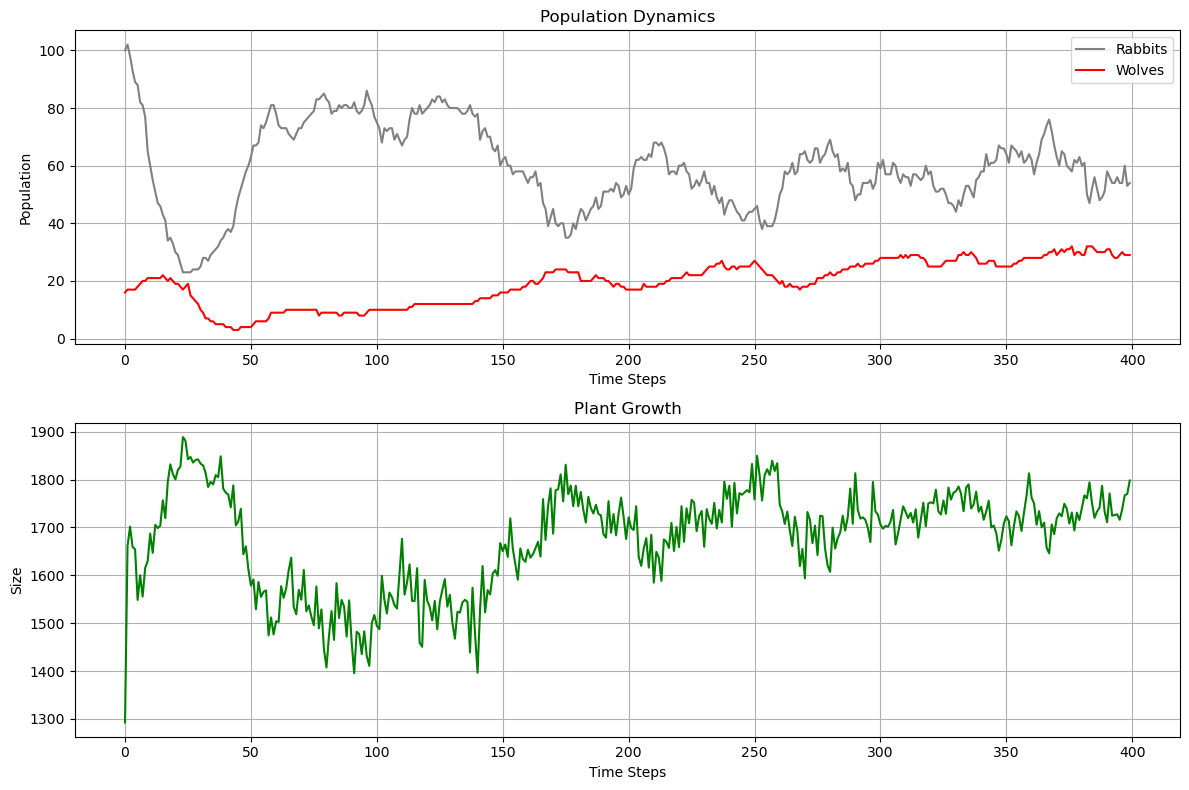

In [1149]:
# --- Theory: ---
# The following block runs the simulation and visualizes population dynamics.

rabbit_properties = RabbitProperties(
    eat_amount=(4, 14),
    eat_rate=(0.2, 0.6),
    emergency_eat_ratio=(1.2, 1.5),
    breed_rate=(0.2, 0.22),
    num_rabbits=100
)

wolf_properties = WolfProperties(
    eat_amount=(15, 25),
    eat_rate=(0.4, 0.6),
    emergency_eat_ratio=(1.2, 1.6),
    breed_rate=(0.2, 0.4),
    num_wolves=16
)

plant_properties = PlantProperties(
    size=rabbit_properties.num_rabbits * 17,
    max_size=rabbit_properties.num_rabbits * 20,
    grow_rate=0.3
)

env = Environment(
    rabbit_properties=rabbit_properties,
    plant_properties=plant_properties,
    wolf_properties=wolf_properties
)
num_steps = 400

for _ in range(num_steps):
    env.simulate()

# Extract data for plotting
steps = range(len(env.report))
rabbit_counts = [report['num_rabbits'] for report in env.report]
wolf_counts = [report['num_wolves'] for report in env.report]
plant_sizes = [report['plant_size'] for report in env.report]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot population dynamics
ax1.plot(steps, rabbit_counts, label='Rabbits', color='gray')
ax1.plot(steps, wolf_counts, label='Wolves', color='red')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Population')
ax1.set_title('Population Dynamics')
ax1.legend()
ax1.grid(True)

# Plot plant size
ax2.plot(steps, plant_sizes, label='Plant Size', color='green')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Size')
ax2.set_title('Plant Growth')
ax2.grid(True)

plt.tight_layout()
plt.show()

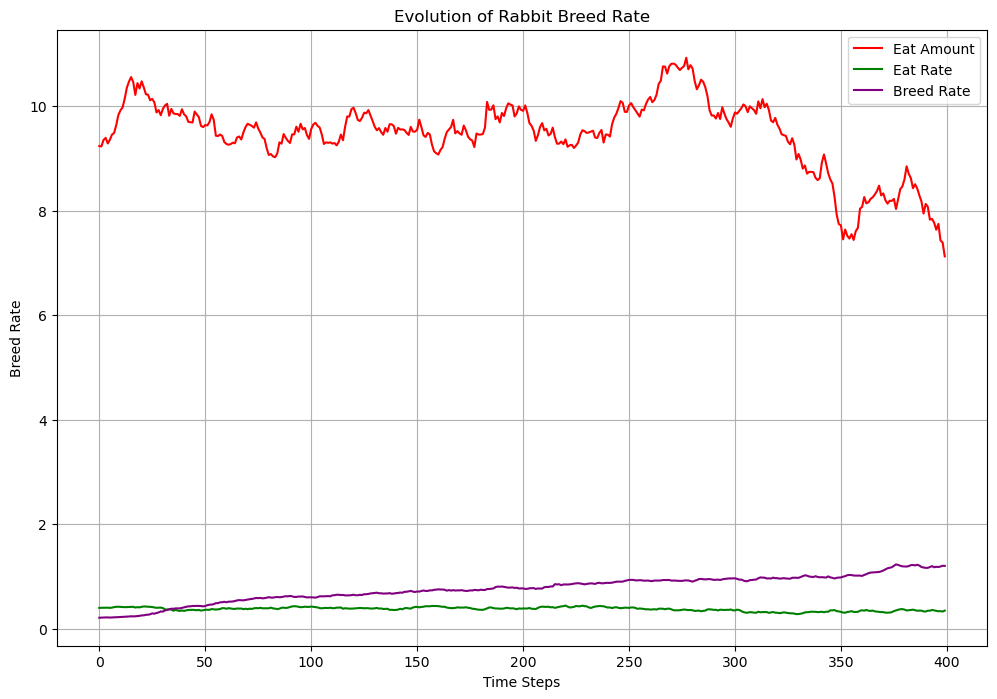

In [1099]:

# env.report[step_index]['rabbit_stats']
rabbit_stats = defaultdict(list)

for step in env.report:
    # rabbit_stats['rabbit_hunger'].append(step['rabbit_stats']['rabbit_hunger'])
    # rabbit_stats['rabbit_age'].append(step['rabbit_stats']['rabbit_age'])
    rabbit_stats['rabbit_eat_amount'].append(step['rabbit_stats']['rabbit_eat_amount'])
    rabbit_stats['rabbit_eat_rate'].append(step['rabbit_stats']['rabbit_eat_rate'])
    # rabbit_stats['rabbit_emergency_eat_ratio'].append(step['rabbit_stats']['rabbit_emergency_eat_ratio'])
    rabbit_stats['rabbit_breed_rate'].append(step['rabbit_stats']['rabbit_breed_rate'])

# Plot Evolution of Rabbit Stats
fig, ax = plt.subplots(figsize=(12, 8))

# Plot rabbit eat amount
ax.plot(steps, rabbit_stats['rabbit_eat_amount'], label='Eat Amount', color='red')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Eat Amount')
ax.set_title('Evolution of Rabbit Eat Amount')
ax.legend()
ax.grid(True)

# Plot rabbit eat rate
ax.plot(steps, rabbit_stats['rabbit_eat_rate'], label='Eat Rate', color='green')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Eat Rate')
ax.set_title('Evolution of Rabbit Eat Rate')
ax.legend()
ax.grid(True)

# Plot rabbit breed rate
ax.plot(steps, rabbit_stats['rabbit_breed_rate'], label='Breed Rate', color='purple')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Breed Rate')
ax.set_title('Evolution of Rabbit Breed Rate')
ax.legend()
ax.grid(True)


In [1072]:
step_index = -1
stats = env.report[step_index]['rabbit_stats']
for key, value in stats.items():
    print(f"{key}: {value}")


rabbit_hunger: 28.824489795918367
rabbit_age: 6.122448979591836
rabbit_eat_amount: 10.061224489795919
rabbit_eat_rate: 0.39244506382375377
rabbit_emergency_eat_ratio: 1.5274452322007115
rabbit_breed_rate: 1.1640785867446133
